# Texture-Based Optical Guided Despeckling of SAR Image

In [1]:
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple, List
import time
import rasterio

from scripts.texture_descriptor import compute_texture_descriptor, rgb2gray, rgb2lab, compute_similarity_map
from scripts.filters import gaussian_kernel_2d
from scripts.despeckling import UBF, DUBF
from scripts.utils import extract_patches, compute_indices_from_n_blocks

print(jax.devices())

[cuda(id=0)]


In [2]:
# opt = Image.open('/home/nus/Downloads/optical_sar_data/optical.png')
# sar = Image.open('/home/nus/Downloads/optical_sar_data/sar.png')

# opt_rgb = jnp.array(opt) / 255.0
# sar = jnp.array(sar) / 255.0
# sar = jnp.expand_dims(sar, axis=-1)  # (H, W, 1)

# opt_gray = rgb2gray(opt_rgb)
# opt_lab = rgb2lab(opt_rgb)

# print(sar.shape, opt_gray.shape, opt_lab.shape)

(500, 500, 3) (500, 500)


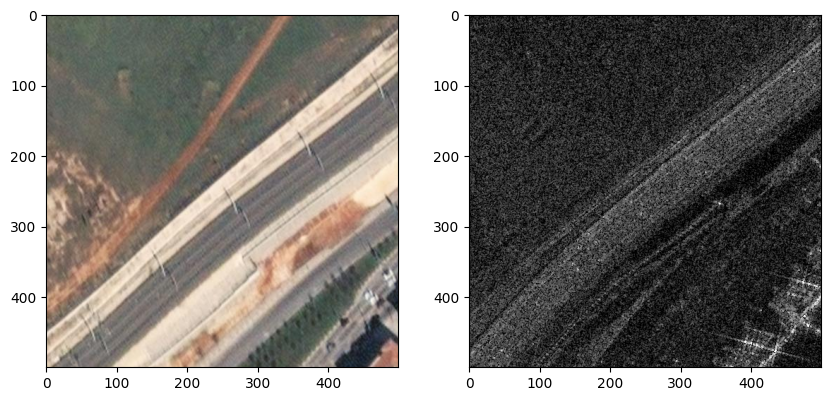

In [3]:
def crop(img: np.ndarray, x0: int, y0: int, size: int) -> np.ndarray:
    """Crop the image to the center with the given size."""
    return img[y0:y0+size, x0:x0+size]

path_opt = '/home/nus/workspace/datasets/spacenet9/train/02_optical_train_01.tif'
path_sar = '/home/nus/workspace/datasets/spacenet9/train/02_sar_train_01.tif'

with rasterio.open(path_opt) as src:
    r = src.read(1)
    g = src.read(2)
    b = src.read(3)
data_opt = np.dstack((r, g, b))

with rasterio.open(path_sar) as src:
    data_sar = src.read(1)

x_center_opt, y_center_opt = data_opt.shape[1] // 2, data_opt.shape[0] // 2
x_center_sar, y_center_sar = data_sar.shape[1] // 2, data_sar.shape[0] // 2

opt_coords = {
    'x0': x_center_opt - 500, 
    'y0': y_center_opt + 500, 
    'size': 500
}

sar_coords = {
    'x0': x_center_sar - 500, 
    'y0': y_center_sar + 300, 
    'size': 500
}

opt = crop(data_opt, **opt_coords)
sar = crop(data_sar, **sar_coords)

print(opt.shape, sar.shape)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(opt)
plt.subplot(1, 2, 2)
plt.imshow(sar, cmap='gray')

In [4]:
opt_rgb = jnp.array(opt) / 255.0
sar = jnp.array(sar) / 255.0
sar = jnp.expand_dims(sar, axis=-1)  # (H, W, 1)

opt_gray = rgb2gray(opt_rgb)
opt_lab = rgb2lab(opt_rgb)

print(sar.shape, opt_gray.shape, opt_lab.shape, opt_rgb.shape)

2025-08-15 15:50:15.049402: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(500, 500, 1) (500, 500, 1) (500, 500, 3) (500, 500, 3)


In [27]:
radius = 7

time_start = time.time()
S = compute_texture_descriptor(opt_lab, radius)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

0.0527 seconds


In [29]:
# replace nan with interpolation
S = jnp.nan_to_num(S, nan=0.0)

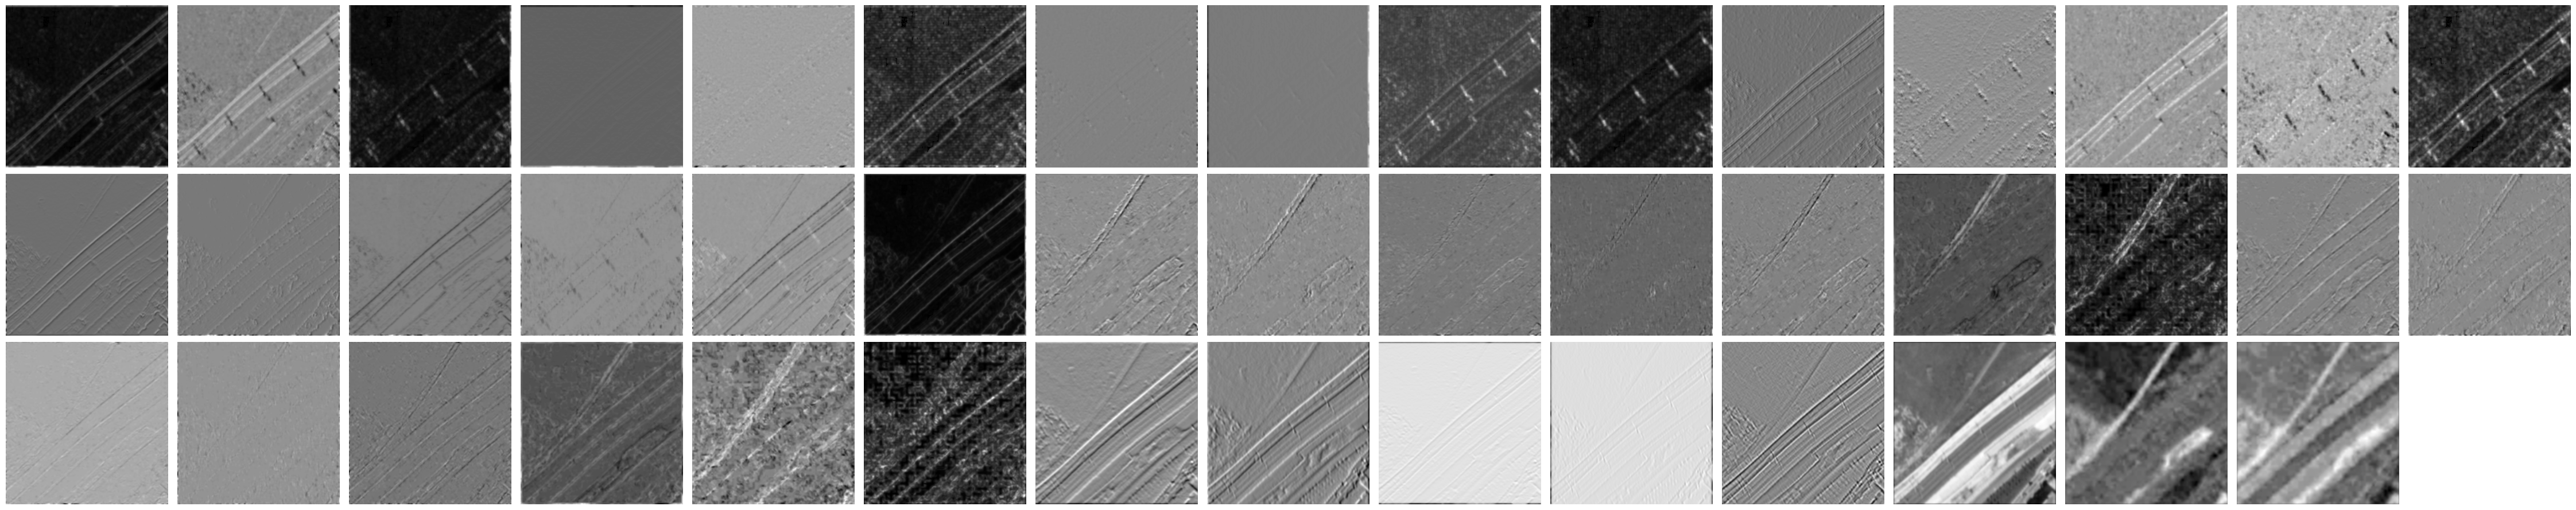

In [30]:
D = S.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

### UBF

In [6]:
# L = opt_gray

# ubf = UBF()
# time_start = time.time()
# S_ubf, error = ubf.filter(S, L, sigma_s=5, sigma_l=0.05, alpha_ubf=2, n_iter=30, n_blocks=2)
# time_end = time.time()
# print(f"{time_end - time_start:.4f} seconds")

In [7]:
# D = S_ubf.shape[-1]

# N = 5  # Number of columns for plotting
# plt.figure(figsize=(N * 3, (D // N + 1) * 3))
# for i in range(D):
#     plt.subplot(D // N + 1, N, i + 1)
#     plt.imshow(S_ubf[:,:,i], cmap='gray')
#     plt.axis('off')
# plt.tight_layout()

In [8]:
# plt.plot(error)
# plt.plot(np.arange(len(error)), np.zeros_like(error), 'k--')

### DUBF

In [31]:
L_opt = opt_gray
L_sar = sar  # (H, W, 1)

dubf = DUBF()
time_start = time.time()
S_dubf, error = dubf.filter(S, L_opt, L_sar, sigma_s=5, sigma_l_opt=0.1, sigma_l_sar=0.1, alpha_ubf=2, n_iter=30, n_blocks=10)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

DUBF Iterations:   0%|          | 0/30 [00:00<?, ?it/s]

DUBF Iterations: 100%|██████████| 30/30 [00:45<00:00,  1.52s/it]

45.7258 seconds


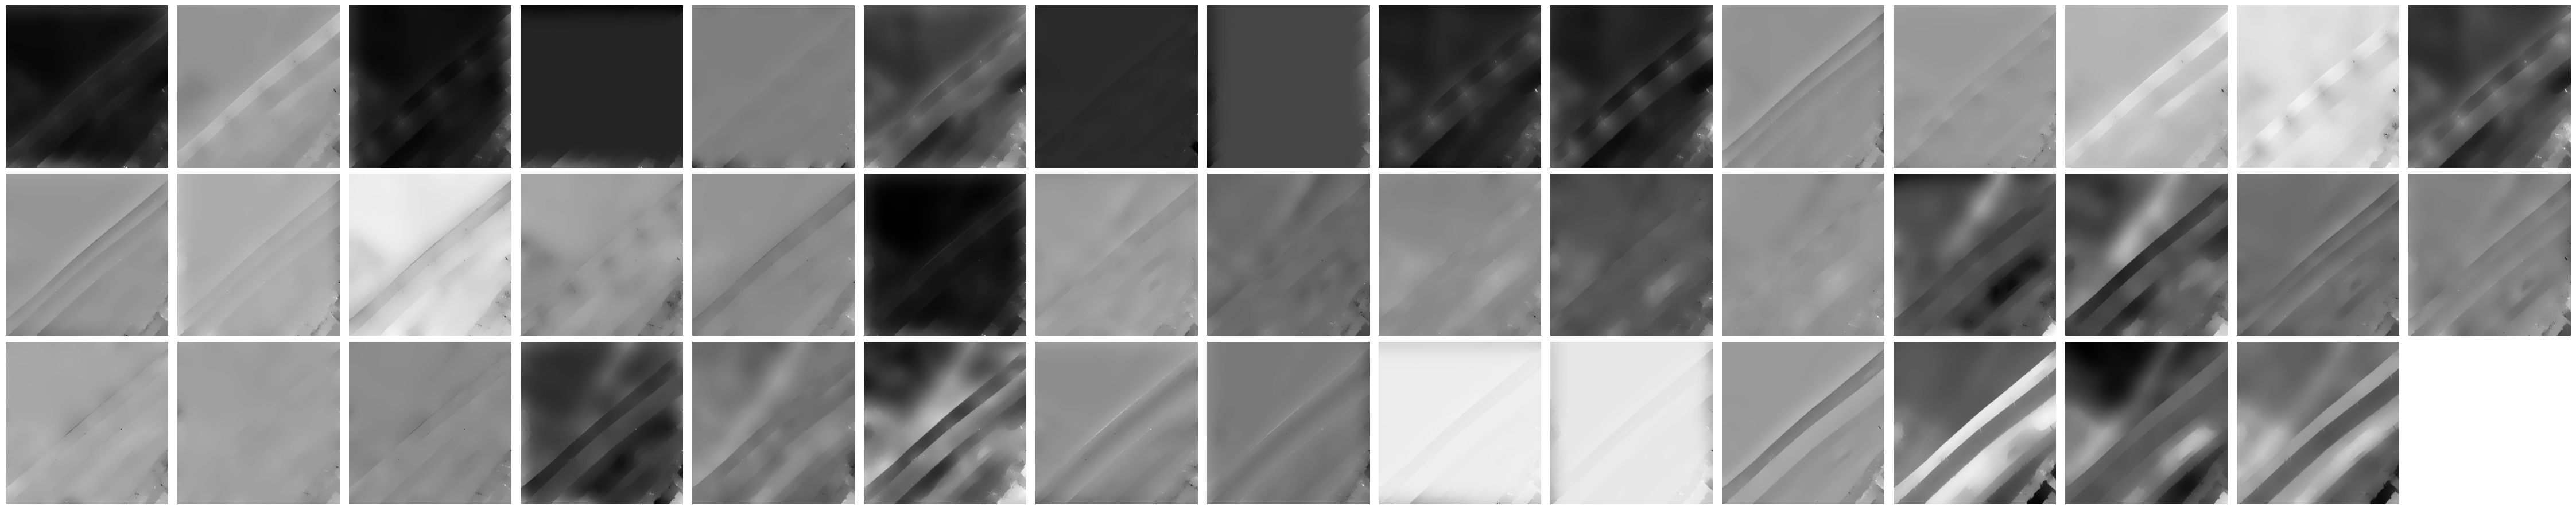

In [32]:
D = S_dubf.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_dubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

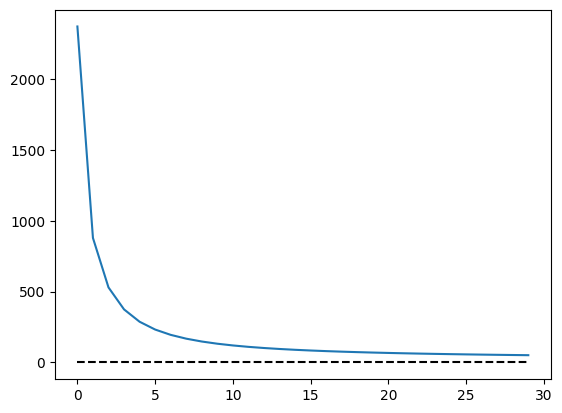

In [33]:
plt.plot(error)
plt.plot(np.arange(len(error)), np.zeros_like(error), 'k--')

### Despeckle

In [34]:
# i, j = 150, 150  # width, height -> x, y
# sigma_d = 3

# similarity_map = compute_similarity_map(S_dubf[j, i, :], S_dubf, sigma_d=sigma_d)  # y, x
# print(similarity_map.shape)

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 1)
# plt.imshow(opt)
# plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
# plt.axis('off')
# plt.subplot(1, 3, 2)
# plt.imshow(sar, cmap='gray')
# plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
# plt.axis('off')
# plt.subplot(1, 3, 3)
# plt.imshow(similarity_map, cmap='jet')
# plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
# plt.axis('off')
# plt.tight_layout()

In [ ]:
def despeckle(sar: jnp.ndarray, S: jnp.ndarray, sigma_d: float, radius: float, n_blocks: int = 10) -> jnp.ndarray:
    H, W, _ = S.shape
    kernel_size = 2 * radius + 1  # k = 2 * r + 1

    # Pad the input arrays to handle borders
    pad_width = ((radius, radius), (radius, radius), (0, 0))
    S_pad = jnp.pad(S.copy(), pad_width, mode='reflect')  # (H+2*r, W+2*r, D)
    sar_pad = jnp.pad(sar.copy(), pad_width, mode='reflect')  # (H+2*r, W+2*r, 1)

    # Precompute Gaussian weights
    Gs = gaussian_kernel_2d(radius).reshape(1, 1, kernel_size, kernel_size, 1)  # (1, 1, k, k, 1)

    # Compute start and end indices for memory efficiency
    start_indices, end_indices = compute_indices_from_n_blocks(n_blocks, H, W, padding=radius)

    sar_filtered = jnp.zeros_like(sar_pad)  # Initialize update tensor
    std = jnp.zeros_like(sar_pad) 

    # Iterate over the blocks
    progress_bar = tqdm(total=len(start_indices), desc="Despeckling", unit="block")
    for start_index, end_index in zip(start_indices, end_indices):
        # Extract windows (patches) for all spatial locations
        S_patches = extract_patches(S_pad, kernel_size, start_index, end_index)   # (H', W', k, k, D)
        sar_patches = extract_patches(sar_pad, kernel_size, start_index, end_index)  # (H', W', k, k, 1)

        S_centers = S_patches[..., radius, radius, :][..., None, None, :]  # Centers are located at (radius, radius)
        diff = S_patches - S_centers # (H', W', k, k, D)
        distsq = jnp.sum((diff)**2, axis=-1) 
        similarity_map = jnp.exp(-distsq / (2 * sigma_d ** 2))

        Gd = similarity_map[..., None]
        w = Gd 
        Z = 1 / w.sum(axis=(-3, -2))  # (H', W')

        update_block = (w * sar_patches).sum(axis=(-3, -2))  # (H', W', 1)
        update_block = update_block * Z # Normalize by the sum of weights

        update_std = (w * (sar_patches - update_block[..., None, None, :])**2).sum(axis=(-3, -2))
        update_std = jnp.sqrt(update_std * Z)

        # Update only the current block
        sar_filtered = jax.lax.dynamic_update_slice(sar_filtered, update_block, start_index + (0,))  
        std = jax.lax.dynamic_update_slice(std, update_std, start_index + (0,))
        progress_bar.update(1)
    progress_bar.close()
    
    # Remove padding
    return sar_filtered[radius:-radius, radius:-radius, :], std[radius:-radius, radius:-radius, :]  

In [36]:
print(S.shape, sar.shape)
sigma_d = 1.5
sigma_s = 75
n_blocks = 100

(500, 500, 44) (500, 500, 1)


In [37]:
time_start = time.time()
sar_filtered, std = despeckle(sar, S, sigma_d=sigma_d, sigma_s=sigma_s, n_blocks=n_blocks)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

Processing blocks:   0%|          | 0/10000 [00:00<?, ?block/s]

Processing blocks: 100%|██████████| 10000/10000 [01:28<00:00, 112.39block/s]

88.9928 seconds


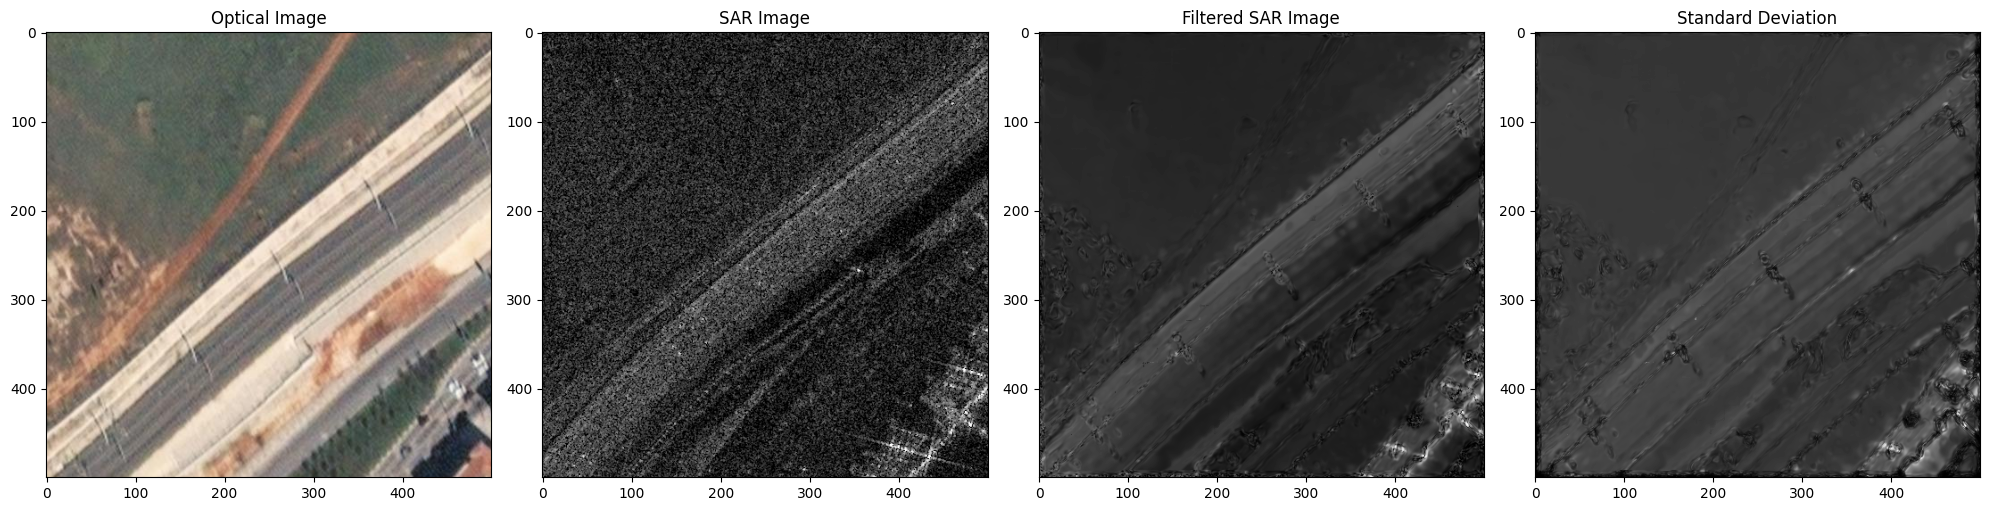

In [39]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(opt)
plt.title('Optical Image')
plt.subplot(1, 4, 2)
plt.imshow(sar, cmap='gray')
plt.title('SAR Image')
plt.subplot(1, 4, 3)
plt.imshow(sar_filtered, cmap='gray')
plt.title('Filtered SAR Image')
plt.subplot(1, 4, 4)
plt.imshow(std, cmap='gray')
plt.title('Standard Deviation')
plt.tight_layout()